# 📈 Long Term Analysis

**Objectif**: Analyser les tendances à long terme des ratings et détecter les évolutions comportementales.

## 🔍 Questions exploratoires:
- Les utilisateurs deviennent-ils plus/moins sévères dans le temps ?
- Quand la plateforme a-t-elle connu ses pics/creux d'activité ?
- Les power users changent-ils leurs habitudes ?
- Y a-t-il eu des événements perturbateurs ?
- La croissance rapide nuit-elle à la qualité ?

In [10]:
# Imports et chargement Long Term Analysis
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, linregress
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from data_utils import *

print("✅ Imports terminés - Prêt pour l'analyse Long Term!")

# Chargement et préparation
df_clean = load_clean_interactions()
print(f"✅ Données chargées: {df_clean.shape}")

# Création des DataFrames temporels
print("🔄 Préparation des séries temporelles...")

# 1. Monthly stats (tendance rating global)
monthly_stats = df_clean.group_by(["year", "month"]).agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort(["year", "month"]).to_pandas()

# 2. Daily stats (détection anomalies et saisonnalité)
daily_stats = df_clean.group_by(["year", "month", "day"]).agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.len().alias("n_interactions")
]).sort(["year", "month", "day"]).to_pandas()

# Création date pour faciliter les plots
monthly_stats['date'] = pd.to_datetime(monthly_stats[['year', 'month']].assign(day=1))
daily_stats['date'] = pd.to_datetime(daily_stats[['year', 'month', 'day']])

# 3. Power user evolution (Evolution comportementale des gros consommateurs)
user_behavior = df_clean.group_by(["user_id", "year", "month"]).agg([
    pl.col("rating").mean().alias("avg_rating"),
    pl.len().alias("n_ratings")
]).with_columns([
    pl.col("n_ratings").quantile(0.8).over(["year", "month"]).alias("power_user_threshold")
]).with_columns([
    pl.when(pl.col("n_ratings") >= pl.col("power_user_threshold"))
    .then(pl.lit("power_user"))
    .otherwise(pl.lit("regular_user"))
    .alias("user_type")
])

print("✅ DataFrames créés avec succès!")
print(f"Monthly stats: {monthly_stats.shape}")
print(f"Daily stats: {daily_stats.shape}")
print(f"User behavior: {user_behavior.shape}")

✅ Imports terminés - Prêt pour l'analyse Long Term!
✅ Données chargées: (1132367, 13)
🔄 Préparation des séries temporelles...
✅ DataFrames créés avec succès!
Monthly stats: (227, 7)
Daily stats: (6396, 7)
User behavior: (507785, 7)
✅ Données chargées: (1132367, 13)
🔄 Préparation des séries temporelles...
✅ DataFrames créés avec succès!
Monthly stats: (227, 7)
Daily stats: (6396, 7)
User behavior: (507785, 7)


📈 ANALYSE TENDANCE LONG TERME
🔍 Test de Mann-Kendall:
Statistique S: -11962
Z-score: -10.4576
P-value: 0.0000
🎯 Résultat: TENDANCE SIGNIFICATIVE - Direction: BAISSE

📊 Régression linéaire:
Pente: -0.002797 points/mois
R²: 0.1499
Évolution annuelle: -0.0336 points/an


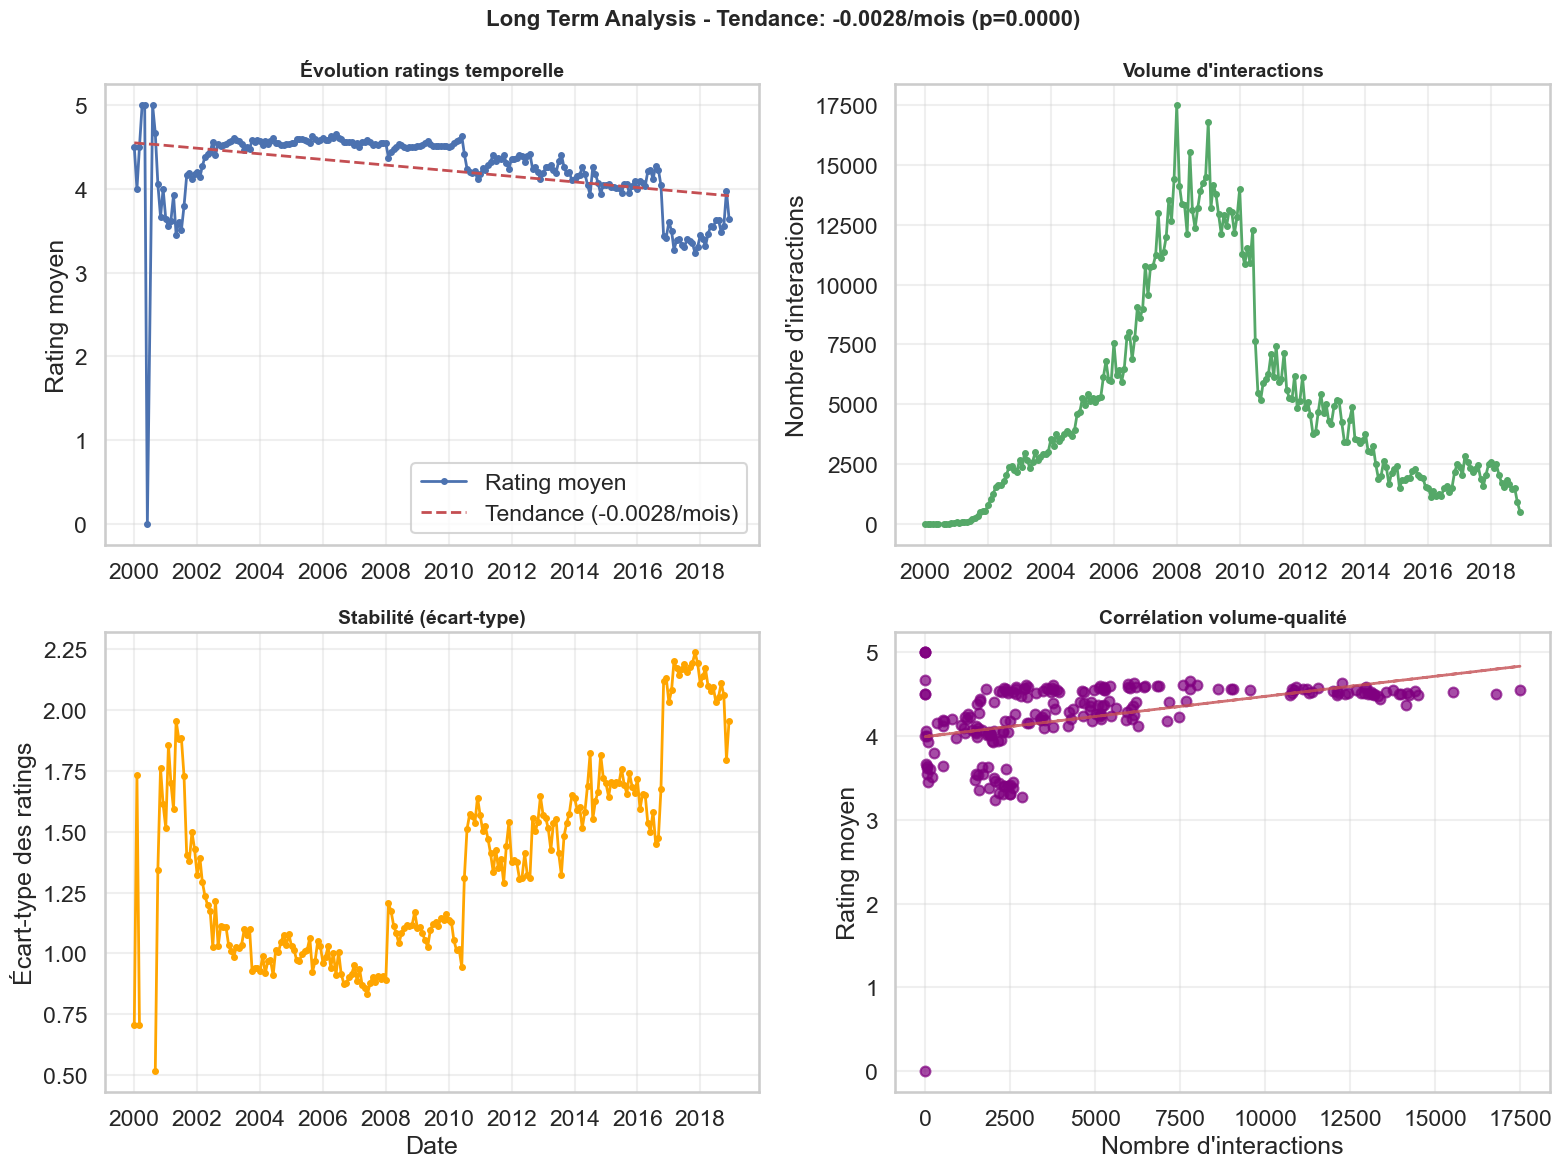


💡 Insights Long Term:
• Direction: Dégradation continue
• Force: 0.0336 points par an
• Fiabilité: R² = 0.150
• Volume-Qualité: ρ = 0.555 (p = 0.0000)
  ✅ Plus d'activité = Meilleure qualité


In [21]:
# 🔍 ANALYSE 1: TENDANCE LONG TERME DES RATINGS
print("=" * 60)
print("📈 ANALYSE TENDANCE LONG TERME")
print("=" * 60)

# Test de Mann-Kendall pour détecter tendance monotone
def mann_kendall_test(data):
    """Implémentation du test de Mann-Kendall pour détecter les tendances"""
    n = len(data)
    s = 0
    
    for i in range(n-1):
        for j in range(i+1, n):
            if data[j] > data[i]:
                s += 1
            elif data[j] < data[i]:
                s -= 1
    
    # Variance
    var_s = n * (n-1) * (2*n+5) / 18
    
    # Statistique de test
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # P-value (bilatéral)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return z, p_value, s

# Application du test
z_mk, p_mk, s_mk = mann_kendall_test(monthly_stats['mean_rating'].values)

print(f"🔍 Test de Mann-Kendall:")
print(f"Statistique S: {s_mk}")
print(f"Z-score: {z_mk:.4f}")
print(f"P-value: {p_mk:.4f}")

interpretation = "TENDANCE SIGNIFICATIVE" if p_mk < 0.05 else "PAS DE TENDANCE CLAIRE"
direction = "HAUSSE" if s_mk > 0 else "BAISSE" if s_mk < 0 else "STABLE"
print(f"🎯 Résultat: {interpretation} - Direction: {direction}")

# Régression linéaire pour quantifier (implémentation native)
X = np.arange(len(monthly_stats))
y = monthly_stats['mean_rating'].values

# Calcul de la régression linéaire avec scipy
trend_slope, intercept, r_value, p_value_reg, std_err = linregress(X, y)
trend_r2 = r_value ** 2

print(f"\n📊 Régression linéaire:")
print(f"Pente: {trend_slope:.6f} points/mois")
print(f"R²: {trend_r2:.4f}")
print(f"Évolution annuelle: {trend_slope * 12:.4f} points/an")

# Visualisation tendance avec Matplotlib (plus stable)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Tendance rating
ax1.plot(monthly_stats['date'], monthly_stats['mean_rating'], 'bo-', linewidth=2, markersize=4, label='Rating moyen')
# Ligne de tendance
trend_line = intercept + trend_slope * X
ax1.plot(monthly_stats['date'], trend_line, 'r--', linewidth=2, label=f'Tendance ({trend_slope:.4f}/mois)')
ax1.set_title("Évolution ratings temporelle", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating moyen")
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Volume d'interactions
ax2.plot(monthly_stats['date'], monthly_stats['n_interactions'], 'go-', linewidth=2, markersize=4)
ax2.set_title("Volume d'interactions", fontsize=14, fontweight='bold')
ax2.set_ylabel("Nombre d'interactions")
ax2.grid(True, alpha=0.3)

# 3. Stabilité (écart-type)
ax3.plot(monthly_stats['date'], monthly_stats['std_rating'], 'o-', color='orange', linewidth=2, markersize=4)
ax3.set_title("Stabilité (écart-type)", fontsize=14, fontweight='bold')
ax3.set_ylabel("Écart-type des ratings")
ax3.set_xlabel("Date")
ax3.grid(True, alpha=0.3)

# 4. Scatter volume vs qualité
ax4.scatter(monthly_stats['n_interactions'], monthly_stats['mean_rating'], 
           color='purple', alpha=0.7, s=50)
ax4.set_title("Corrélation volume-qualité", fontsize=14, fontweight='bold')
ax4.set_xlabel("Nombre d'interactions")
ax4.set_ylabel("Rating moyen")
ax4.grid(True, alpha=0.3)

# Ajout de la ligne de corrélation
z = np.polyfit(monthly_stats['n_interactions'], monthly_stats['mean_rating'], 1)
p = np.poly1d(z)
ax4.plot(monthly_stats['n_interactions'], p(monthly_stats['n_interactions']), 
         "r--", alpha=0.8, linewidth=2)

plt.suptitle(f"Long Term Analysis - Tendance: {trend_slope:+.4f}/mois (p={p_mk:.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 Insights Long Term:")
print(f"• Direction: {'Amélioration' if trend_slope > 0 else 'Dégradation'} continue")
print(f"• Force: {abs(trend_slope * 12):.4f} points par an")
print(f"• Fiabilité: R² = {trend_r2:.3f}")

# Corrélation volume vs qualité
corr_vol_qual, p_corr = spearmanr(monthly_stats['n_interactions'], monthly_stats['mean_rating'])
print(f"• Volume-Qualité: ρ = {corr_vol_qual:.3f} (p = {p_corr:.4f})")

if p_corr < 0.05:
    if corr_vol_qual > 0:
        print("  ✅ Plus d'activité = Meilleure qualité")
    else:
        print("  ⚠️ Plus d'activité = Qualité dégradée")
else:
    print("  ℹ️ Pas de lien significatif volume-qualité")

# Rating Analysis - Long Term Trends

Analyse des tendances long terme des ratings : évolution annuelle, dérive temporelle, impact des power users.

In [13]:
# Import du module utilitaire Python (plus robuste que %run)
import sys
sys.path.append('../')

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python
from data_utils import *

# Imports spécifiques à l'analyse long terme
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

sns.set_theme(style="whitegrid", context="talk")

print("✅ Imports terminés - Module data_utils chargé")

✅ Imports terminés - Module data_utils chargé


## 📥 Chargement des données transformées

In [14]:
# Chargement direct des données transformées (propres et enrichies)
df_enriched = load_clean_interactions()

# Focus sur les données avec ratings valides
df_rated = df_enriched.filter(pl.col("rating") > 0)

# Rapport qualité sur les données transformées
report = analyze_data_quality(df_rated, "Interactions transformées (ratings > 0)")
print_quality_report(report)

print(f"\n📊 Dataset prêt pour analyse long terme: {df_rated.shape[0]:,} interactions")
print(f"📅 Période couverte: {df_rated['year'].min()} - {df_rated['year'].max()}")
print(f"🔧 Features disponibles: {', '.join([col for col in df_rated.columns if col in ['year', 'month', 'season', 'is_weekend', 'normalized_rating', 'rating_category']])}")

📊 Rapport de qualité : Interactions transformées (ratings > 0)
Shape: (1071520, 13)
Duplicatas: 0

🌟 Ratings:
  Moyenne: 4.661 ± 0.723
  Range: [1, 5]
  Zéros: 0, Invalides: 0

📅 Dates: 2000-01-25 → 2018-12-20

📊 Dataset prêt pour analyse long terme: 1,071,520 interactions
📅 Période couverte: 2000 - 2018
🔧 Features disponibles: year, month, is_weekend, season, normalized_rating, rating_category


## 📈 Analyse tendances annuelles

In [15]:
# Préparation des données mensuelles
monthly_evolution = df_rated.group_by(["year", "month"]).agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions"),
]).sort(["year", "month"])

# Création d'une date pour le plotting
monthly_pd = monthly_evolution.to_pandas()
monthly_pd['date'] = pd.to_datetime(monthly_pd[['year', 'month']].assign(day=1))

print("📅 Évolution mensuelle (aperçu):")
display(monthly_pd.head(10))

📅 Évolution mensuelle (aperçu):


,year,month,mean_rating,median_rating,std_rating,n_interactions,date
0,2000,1,4.500000,4.5,0.707107,2,2000-01-01
1,2000,2,4.000000,5.0,1.732051,3,2000-02-01
2,2000,3,4.500000,4.5,0.707107,2,2000-03-01
3,2000,4,5.000000,5.0,NaN,1,2000-04-01
4,2000,5,5.000000,5.0,NaN,1,2000-05-01
5,2000,8,5.000000,5.0,NaN,1,2000-08-01
6,2000,9,4.666667,5.0,0.516398,6,2000-09-01
7,2000,10,4.312500,5.0,0.873212,16,2000-10-01
8,2000,11,4.033333,5.0,1.376736,30,2000-11-01
9,2000,12,4.315789,5.0,1.187895,38,2000-12-01


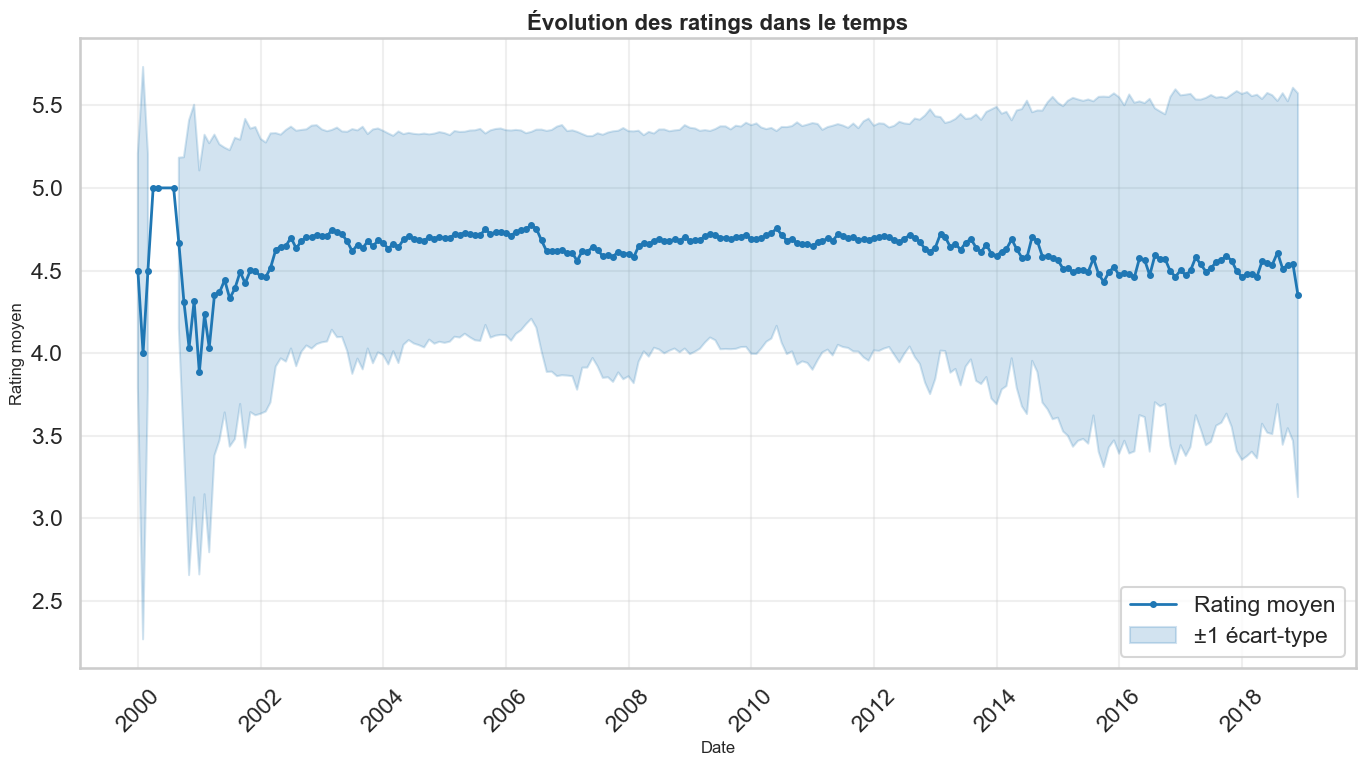

In [22]:
# Graphique évolution long terme avec Matplotlib
fig, ax = plt.subplots(figsize=(14, 8))

# Ligne principale : moyenne mobile
ax.plot(monthly_pd['date'], monthly_pd['mean_rating'], 'o-', 
        color='#1f77b4', linewidth=2, markersize=4, label='Rating moyen')

# Bandes de confiance (±1 std)
ax.fill_between(monthly_pd['date'], 
                monthly_pd['mean_rating'] - monthly_pd['std_rating'],
                monthly_pd['mean_rating'] + monthly_pd['std_rating'],
                alpha=0.2, color='#1f77b4', label='±1 écart-type')

ax.set_title('Évolution des ratings dans le temps', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rating moyen', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()

# Rotation des dates pour meilleure lisibilité
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 📊 Analyse de volume vs qualité

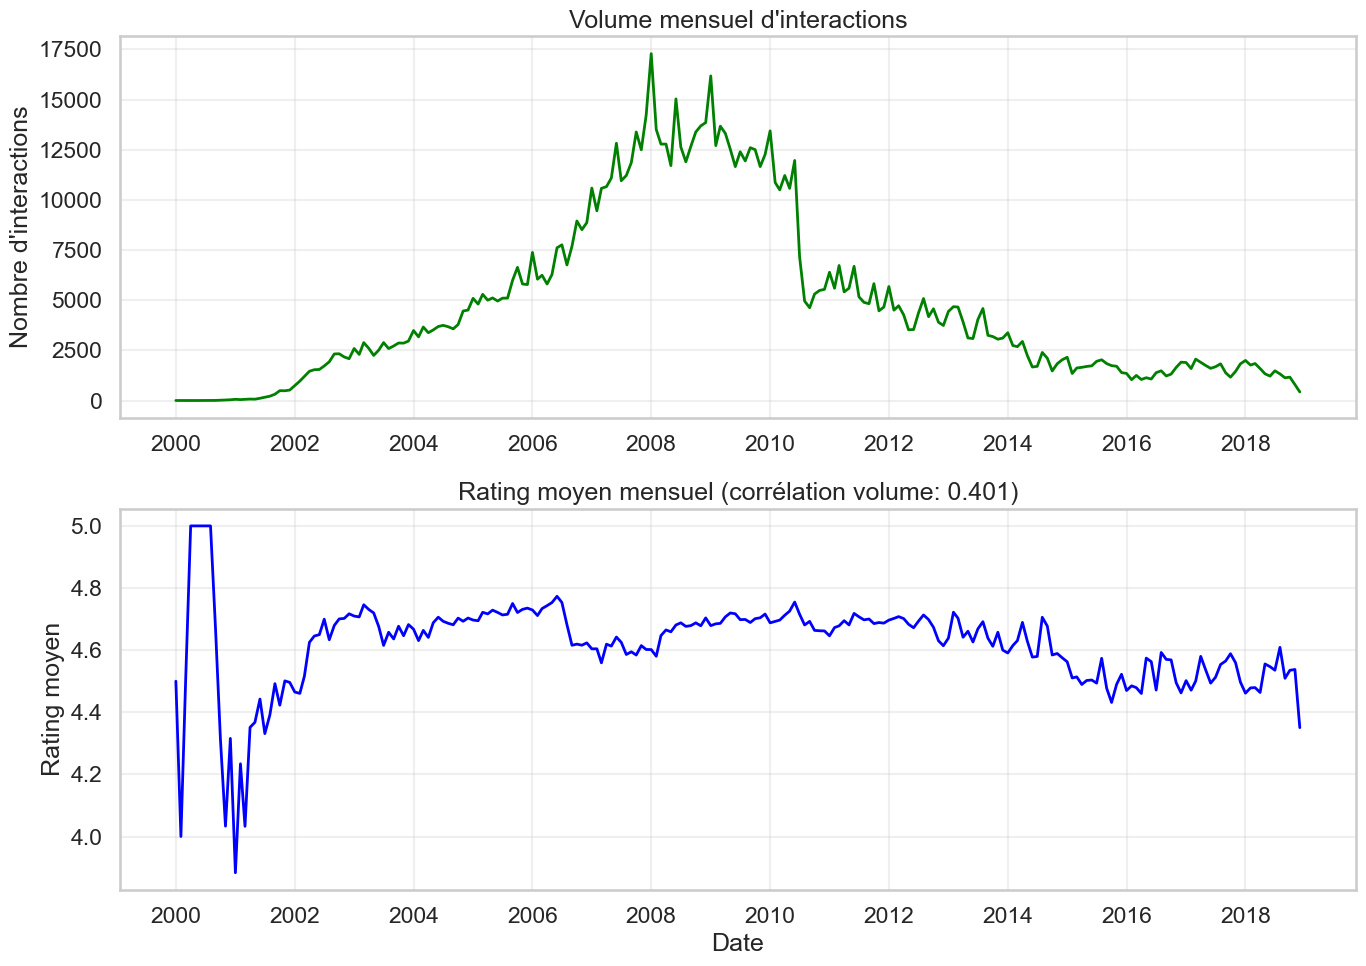

📈 Corrélation volume/rating: 0.401
⚠️  Corrélation notable - à investiguer


In [17]:
# Corrélation volume/rating par mois
correlation = monthly_pd[['n_interactions', 'mean_rating']].corr().iloc[0, 1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Volume mensuel
ax1.plot(monthly_pd['date'], monthly_pd['n_interactions'], color='green', linewidth=2)
ax1.set_title('Volume mensuel d\'interactions')
ax1.set_ylabel('Nombre d\'interactions')
ax1.grid(True, alpha=0.3)

# Rating mensuel
ax2.plot(monthly_pd['date'], monthly_pd['mean_rating'], color='blue', linewidth=2)
ax2.set_title(f'Rating moyen mensuel (corrélation volume: {correlation:.3f})')
ax2.set_ylabel('Rating moyen')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Corrélation volume/rating: {correlation:.3f}")
if abs(correlation) > 0.3:
    print("⚠️  Corrélation notable - à investiguer")
else:
    print("✅ Faible corrélation volume/qualité")

## 📈 Tests statistiques de tendance

In [19]:
# Test de Mann-Kendall pour détecter une tendance temporelle
from scipy.stats import kendalltau

# Préparation des données pour le test
monthly_sorted = monthly_pd.sort_values('date')
time_index = range(len(monthly_sorted))
ratings = monthly_sorted['mean_rating'].values

# Test de corrélation de Kendall (approximation du Mann-Kendall)
tau, p_value = kendalltau(time_index, ratings)

print(f"📊 Test de tendance temporelle:")
print(f"   Tau de Kendall: {tau:.4f}")
print(f"   p-value: {p_value:.4f}")

if p_value < 0.05:
    direction = "croissante" if tau > 0 else "décroissante"
    print(f"   ✅ Tendance {direction} significative")
else:
    print(f"   ❌ Pas de tendance significative")

# Régression linéaire pour quantifier la pente
from scipy.stats import linregress
slope, intercept, r_value, p_value_reg, std_err = linregress(time_index, ratings)

print(f"\n📈 Régression linéaire:")
print(f"   Pente: {slope:.6f} points/mois")
print(f"   R²: {r_value**2:.4f}")
print(f"   p-value: {p_value_reg:.4f}")

# Pente annualisée
annual_slope = slope * 12
print(f"   📅 Évolution annuelle: {annual_slope:.4f} points/an")

📊 Test de tendance temporelle:
   Tau de Kendall: -0.2109
   p-value: 0.0000
   ✅ Tendance décroissante significative

📈 Régression linéaire:
   Pente: -0.000142 points/mois
   R²: 0.0045
   p-value: 0.3131
   📅 Évolution annuelle: -0.0017 points/an
